In [256]:
import numpy as np
import skimage
from skimage import io
import matplotlib.pyplot as plt

In [283]:
# current script implementations

def cov(x_i, x_j, r=1.0, a=1.0):
    """ The covariance function that determines smoothness of GP
    It encodes some similarity about points near each other
    x_i and x_j are the indexes to those points, hence they are
    technically the same vector and the logic for batch calculations
    is done here instead of separate indexing of i,j coordinates
    x_i has shape m x d
    x_j  has shape n x d
    out has shape m x n (cov matrix between all points)
    """
    x_i_sum = np.sum(x_i**2, axis=1).reshape(-1, 1)
    x_j_sum = np.sum(x_j**2, axis=1)
    dist = x_i_sum + x_j_sum - (2 * np.dot(x_i, x_j.T))
    out = a * np.exp(-(dist / r**2))
    return out


def transform_mat(x_i, x_j, center, shift, angle, gamma):
    """ This is the transformation matrix that converts a high
    resolution image into a low resolution image
    In the paper this is denoted using W_ji
    Remember normalization
    """
    x_i_sum = np.sum(x_i**2, axis=1).reshape(-1, 1)
    u_j = psf_center(x_j, center, shift, angle)
    u_j_sum = np.sum(u_j**2, axis=1)
    dist = x_i_sum + u_j_sum - (2 * np.dot(x_i, u_j.T))
    out = np.exp(-(dist / gamma**2))
    # below could be incorrect, remember to change to axis=1 if results are poor
    out /= np.sum(out, axis=0)
    return out


def psf_center(x_j, center, shift, angle):
    """ Used to calculate the center of the psf
    This is the vector u_j in the paper

    In the 1D case, we leave out the rotation
    """
    center = center.reshape(-1,2)
    shift = shift.reshape(-1,2)
    if isinstance(angle, np.ndarray):
        angle = angle.reshape(-1, 1)
    rotation_matrix = [
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]]
    
    u = np.dot(rotation_matrix, (x_j - center).T)
    u = u.T + center + shift
    # u = x_j + shift
    # in the 2d case, u = center + shifts.reshape(-1,2)
    return u


def variance(Z_x, W_vec, W, beta):
    Z_x_inv = np.linalg.inv(Z_x)
    #d = 0
    #for k in range(len(W)):
    #    d += np.dot(W_vec.T, W[k])
    a = np.dot(W_vec, W)
    a = np.sum(a, axis=0)
    sigma = Z_x_inv + (beta * a)
    return np.linalg.inv(sigma)


def mean(WK, y, beta, sigma):
    """
    :param WK:
    :param y: a kxM dimension matrix
    :param beta:
    :param sigma:
    :return:
    """
    #a = 0
    #for k in range(len(y)):
    #    a += np.dot(WK.T, y[k])
    a = np.dot(WK.T, y)
    a = np.sum(a, axis=0)
    mu = beta * np.matmul(sigma, a)
    return mu


def marginal_log_likelihood(beta, y, W, mu, Z_x, sigma, K, M):
    sigma = variance(Z_x, W, W, beta)  # arguments need to be changed here for the first W
    mu = mean(W, y, beta, sigma)

    y_sum = np.sum(y**2, axis=1)
    W_u = np.matmul(W, mu)
    W_u_sum = np.sum(W_u**2, axis=1)
    likelihood = y_sum + W_u_sum - (2 * np.dot(y_sum, W_u.T))
    likelihood *= beta

    likelihood += np.matmul(np.dot(mu.T, np.linalg.inv(Z_x)), mu)
    likelihood += np.log(np.linalg.det(Z_x)) - np.log(np.linalg.det(sigma)) - (K * M * np.log(beta))
    likelihood *= -0.5
    return likelihood


# gamma is a learnable parameter
def compute_likelihood(X, y, center, shifts, gamma):
    # takes in the necessary parameters to calculate everything and return a likelihood score
    pass

In [277]:
ls ../images

rose.jpg


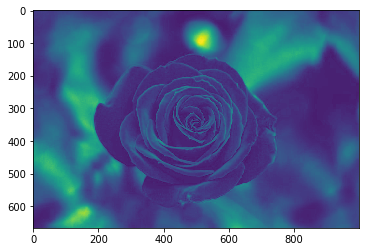

In [278]:
image = io.imread('../images/rose.jpg')[:,:,2]
plt.imshow(image)

In [279]:
flat_img_col = flat_img.T
flat_img_col = 0.5 * (2 * (flat_img_col-np.min(flat_img_col))/(np.max(flat_img_col)-np.min(flat_img_col)) - 1)
X = np.arange(81).reshape(-1, 1)

In [280]:
def get_coords(height, width):
    coords = []
    for h in range(height):
        for w in range(width):
            coords.append([h, w])
    return np.array(coords)

def normalize(image):
    return 0.5 * (2 * (image-np.min(image))/(np.max(image)-np.min(image)) - 1)

In [281]:
# X denotes the points on the function i.e f(X). In pixel space, this
# is discrete so we have an array [0 ... 80]

X_m = get_coords(9, 9)
X_n = get_coords(18, 18)

K = 16
# y denotes the set of low resolution images of dimension kxM
y = []
y.append(normalize(image[300:309, 400:409].flatten()))
# Center is the center of the image
center = np.array([40, 40])
# shifts is the shift of each image
shifts = []
shifts.append(np.array([0, 0]))

# angles denote the amount of rotation for each images
angles = []
angles.append(0)

for _ in range(K-1):
    xshift = np.random.randint(-2, 2)
    yshift = np.random.randint(-2, 2)
    shifts.append([xshift, yshift])
    angles.append(0)
    y.append(normalize(image[300+yshift:309+yshift, 400+xshift:409+xshift].flatten()))
y = np.array(y)
centers = np.array(centers)
shifts = np.array(shifts)
angles = np.array(angles)

#y, centers, shifts

In [282]:
transform_mat(X_n, X_m, center, shifts, angles, gamma=2)

(16, 1)


ValueError: shapes (2,2,16,1) and (2,81) not aligned: 1 (dim 3) != 2 (dim 0)

In [273]:
variance(Z_x, W_vec, W_ji, beta=0.05)

NameError: name 'W_vec' is not defined